In [1205]:
import numpy as np
import pandas as pd
from datetime import datetime

import plotly.graph_objects as go
from ta.trend import MACD

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


from matplotlib import pyplot as plt

pd.get_option("display.max_columns")

20

In [1206]:
def load_configs(config: str = "btc"):
    is_time_aggregate = False
    if config == "btc":
        filename = "test.csv"
        trades_per_candle = 1000
        do_aggregate = False
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy"])
    elif config == "eth":        
        filename = "test_ethusd.csv"
        trades_per_candle = 1000
        do_aggregate = True
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy"])
    else:
        filename = "test_ethusdt_time_series.csv"
        trades_per_candle = 1000
        do_aggregate = False
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy", "Trades"])
        is_time_aggregate = True
    threshold = 0.0
    return filename, trades_per_candle, do_aggregate, threshold, df, is_time_aggregate

filename, trades_per_candle, do_aggregate, threshold, df, is_time_aggregate = load_configs("else")

In [1207]:
df["Timestamp"] = df["Timestamp"].apply(lambda row: pd.to_datetime(row,unit='ms'))

def draw(df):
    fig = go.Figure(data=[go.Candlestick(x=df['Timestamp'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()
draw(df)

In [1208]:
df.head(50)

,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades
0,2900.48,2903.03,2899.28,2902.23,5.644723e+05,2021-09-28 10:30:34.524,140,361
1,2902.08,2902.23,2894.81,2896.95,8.312620e+05,2021-09-28 10:31:34.911,250,431
2,2896.99,2902.34,2896.99,2901.09,5.649050e+05,2021-09-28 10:32:35.495,162,284
3,2901.34,2904.62,2900.80,2904.62,3.378702e+05,2021-09-28 10:33:35.565,99,251
4,2904.63,2906.77,2903.32,2905.66,8.657689e+05,2021-09-28 10:34:35.747,230,469
5,2905.66,2905.66,2898.45,2901.02,2.868255e+05,2021-09-28 10:35:36.178,168,277
6,2901.01,2905.01,2900.00,2904.94,3.505611e+05,2021-09-28 10:36:36.953,136,267
7,2904.94,2906.06,2902.22,2903.05,3.088425e+05,2021-09-28 10:37:36.960,155,276
8,2903.14,2903.14,2898.29,2899.71,9.597596e+05,2021-09-28 10:38:38.481,211,487
9,2899.60,2899.92,2893.44,2897.53,1.067996e+06,2021-09-28 10:39:38.776,340,610


In [1209]:
def aggregate(each: int = 10):
    new_df = pd.DataFrame()
    new_df["Open"] = df["Open"].groupby(df.index // each).first()
    new_df["High"] = df["High"].groupby(df.index // each).max()
    new_df["Low"] = df["Low"].groupby(df.index // each).min()
    new_df["Close"] = df["Close"].groupby(df.index // each).last()
    new_df["Volume"] = df["Volume"].groupby(df.index // each).sum()
    new_df["Timestamp"] = df["Timestamp"].groupby(df.index // each).min()
    new_df["SelltoBuy"] = df["SelltoBuy"].groupby(df.index // each).sum()
    return new_df

if do_aggregate:
    new_df = aggregate()

In [1210]:
if do_aggregate:
    df = new_df
    draw(df)

In [1211]:
df.tail(50)

,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades
2318,2974.95,2976.11,2972.30,2975.68,4.975015e+05,2021-09-30 03:31:10.237,236,562
2319,2975.63,2976.70,2972.29,2973.23,5.324064e+05,2021-09-30 03:32:10.276,218,470
2320,2973.23,2975.71,2972.88,2975.49,3.117417e+05,2021-09-30 03:33:10.285,161,427
2321,2975.49,2975.64,2972.22,2972.90,4.239320e+05,2021-09-30 03:34:10.404,176,399
2322,2972.83,2975.26,2972.82,2974.53,2.901788e+05,2021-09-30 03:35:10.592,127,307
2323,2974.53,2978.95,2973.45,2978.25,4.740901e+05,2021-09-30 03:36:11.029,194,484
2324,2978.29,2979.08,2977.22,2978.86,3.216066e+05,2021-09-30 03:37:11.441,108,269
2325,2978.86,2981.05,2978.42,2979.99,7.423592e+05,2021-09-30 03:38:11.743,157,457
2326,2980.47,2994.26,2980.07,2985.46,7.068690e+06,2021-09-30 03:39:12.245,991,2363
2327,2985.47,2996.22,2985.37,2995.30,4.758178e+06,2021-09-30 03:40:12.420,718,1696


In [1212]:
# df.to_csv('ethbtc.csv', index=False)

In [1213]:
def create_signal(signal_col_name:str = "simple_signal", buy_side_col:str = "pct_change", sell_side_col:str = "pct_change"):
    conditions = [(df[buy_side_col] > threshold), (df[sell_side_col] < -threshold)]
    choices = [1, -1]
    df[signal_col_name] = np.select(conditions, choices, default=0)


def signal_analytics(signal_col_name: str = "simple_signal"):
    signals_total = df[signal_col_name][df[signal_col_name] != 0].count()
    df_len = len(df)
    print(f"Buy signals total: {df[signal_col_name][df[signal_col_name] > 0].sum()}")
    print(f"Sell signals total: {abs(df[signal_col_name][df[signal_col_name] < 0].sum())}")
    print(f"Signals total: {signals_total}")
    print(f"Candles observed: {df_len}")
    print(f"Signal to candle ratio: {round(signals_total/df_len, 4)*100}%")


In [1214]:
df['pct_change'] = df["Close"].pct_change() * 100

create_signal()
signal_analytics()
df.tail(50)

Buy signals total: 1177
Sell signals total: 1185
Signals total: 2362
Candles observed: 2368
Signal to candle ratio: 99.75%


,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades,pct_change,simple_signal
2318,2974.95,2976.11,2972.30,2975.68,4.975015e+05,2021-09-30 03:31:10.237,236,562,0.024874,1
2319,2975.63,2976.70,2972.29,2973.23,5.324064e+05,2021-09-30 03:32:10.276,218,470,-0.082334,-1
2320,2973.23,2975.71,2972.88,2975.49,3.117417e+05,2021-09-30 03:33:10.285,161,427,0.076012,1
2321,2975.49,2975.64,2972.22,2972.90,4.239320e+05,2021-09-30 03:34:10.404,176,399,-0.087044,-1
2322,2972.83,2975.26,2972.82,2974.53,2.901788e+05,2021-09-30 03:35:10.592,127,307,0.054829,1
2323,2974.53,2978.95,2973.45,2978.25,4.740901e+05,2021-09-30 03:36:11.029,194,484,0.125062,1
2324,2978.29,2979.08,2977.22,2978.86,3.216066e+05,2021-09-30 03:37:11.441,108,269,0.020482,1
2325,2978.86,2981.05,2978.42,2979.99,7.423592e+05,2021-09-30 03:38:11.743,157,457,0.037934,1
2326,2980.47,2994.26,2980.07,2985.46,7.068690e+06,2021-09-30 03:39:12.245,991,2363,0.183558,1
2327,2985.47,2996.22,2985.37,2995.30,4.758178e+06,2021-09-30 03:40:12.420,718,1696,0.329597,1


In [1215]:
df['open_high_pct_change'] = (df['High'] - df['Open']) / df['Open'] * 100
df['open_low_pct_change'] = (df["Low"] - df["Open"]) / df["Open"] * 100

signal_take_profit = "signal_take_profit"

create_signal(signal_take_profit, "open_high_pct_change", "open_low_pct_change")
signal_analytics(signal_col_name = signal_take_profit)

df.tail(50)

Buy signals total: 2203
Sell signals total: 165
Signals total: 2368
Candles observed: 2368
Signal to candle ratio: 100.0%


,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit
2318,2974.95,2976.11,2972.30,2975.68,4.975015e+05,2021-09-30 03:31:10.237,236,562,0.024874,1,0.038992,-0.089077,1
2319,2975.63,2976.70,2972.29,2973.23,5.324064e+05,2021-09-30 03:32:10.276,218,470,-0.082334,-1,0.035959,-0.112245,1
2320,2973.23,2975.71,2972.88,2975.49,3.117417e+05,2021-09-30 03:33:10.285,161,427,0.076012,1,0.083411,-0.011772,1
2321,2975.49,2975.64,2972.22,2972.90,4.239320e+05,2021-09-30 03:34:10.404,176,399,-0.087044,-1,0.005041,-0.109898,1
2322,2972.83,2975.26,2972.82,2974.53,2.901788e+05,2021-09-30 03:35:10.592,127,307,0.054829,1,0.081740,-0.000336,1
2323,2974.53,2978.95,2973.45,2978.25,4.740901e+05,2021-09-30 03:36:11.029,194,484,0.125062,1,0.148595,-0.036308,1
2324,2978.29,2979.08,2977.22,2978.86,3.216066e+05,2021-09-30 03:37:11.441,108,269,0.020482,1,0.026525,-0.035927,1
2325,2978.86,2981.05,2978.42,2979.99,7.423592e+05,2021-09-30 03:38:11.743,157,457,0.037934,1,0.073518,-0.014771,1
2326,2980.47,2994.26,2980.07,2985.46,7.068690e+06,2021-09-30 03:39:12.245,991,2363,0.183558,1,0.462679,-0.013421,1
2327,2985.47,2996.22,2985.37,2995.30,4.758178e+06,2021-09-30 03:40:12.420,718,1696,0.329597,1,0.360077,-0.003350,1


In [1216]:
df["sell_to_buy_ratio"] = (df["SelltoBuy"] / trades_per_candle) if not is_time_aggregate else df["SelltoBuy"] / df["Trades"] 
df = df.drop(columns=["SelltoBuy"])

In [1217]:
# df["secs_between_candles"] = df["Timestamp"] - df["Timestamp"].shift(1)
# df["secs_between_candles"] = df['secs_between_candles'].dt.total_seconds()
df = df.drop(columns=["Timestamp"])

In [1218]:
df["ss_next"] = df["simple_signal"].shift(-1)
df["stp_next"] = df["signal_take_profit"].shift(-1)

In [1219]:
# df["vol_pct_change"] = (df["Volume"] - df["Volume"].shift(1))/df["Volume"].shift(1)
# df["vol_per_sec"] = np.log(df["Volume"] / df["secs_between_candles"]) # Can remove log if needed
# df = df.drop(columns=["Volume"])

In [1220]:
indicator_macd = MACD(close = df['Close'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False)
df['macd'] = indicator_macd.macd()
df['macd_diff'] = indicator_macd.macd_diff()
df['momentum'] = df['pct_change'].rolling(5).mean().shift(1)
df['distance'] = (df["Close"] - df["Close"].rolling(50).mean()).shift(1)

In [1221]:
df = df.drop(columns=["Open", "Close", "High", "Low"])

In [1222]:
print(df.shape)
df.head(50)

(2368, 14)


,Volume,Trades,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit,sell_to_buy_ratio,ss_next,stp_next,macd,macd_diff,momentum,distance
0,5.644723e+05,361,NaN,0,0.087916,-0.041372,1,0.387812,-1.0,1.0,NaN,NaN,NaN,NaN
1,8.312620e+05,431,-0.181929,-1,0.005169,-0.250510,1,0.580046,1.0,1.0,NaN,NaN,NaN,NaN
2,5.649050e+05,284,0.142909,1,0.184674,0.000000,1,0.570423,1.0,1.0,NaN,NaN,NaN,NaN
3,3.378702e+05,251,0.121678,1,0.113051,-0.018612,1,0.394422,1.0,1.0,NaN,NaN,NaN,NaN
4,8.657689e+05,469,0.035805,1,0.073675,-0.045100,1,0.490405,-1.0,-1.0,NaN,NaN,NaN,NaN
5,2.868255e+05,277,-0.159688,-1,0.000000,-0.248136,-1,0.606498,1.0,1.0,NaN,NaN,NaN,NaN
6,3.505611e+05,267,0.135125,1,0.137883,-0.034815,1,0.509363,-1.0,1.0,NaN,NaN,-0.008245,NaN
7,3.088425e+05,276,-0.065062,-1,0.038555,-0.093634,1,0.561594,-1.0,-1.0,NaN,NaN,0.055166,NaN
8,9.597596e+05,487,-0.115051,-1,0.000000,-0.167060,-1,0.433265,-1.0,1.0,NaN,NaN,0.013572,NaN
9,1.067996e+06,610,-0.075180,-1,0.011036,-0.212443,1,0.557377,1.0,1.0,NaN,NaN,-0.033774,NaN


In [1223]:
def introduce_shift(depth: int = 1):
    for i in range(depth):
        df[f"pct_change_{i+1}"] = df["pct_change"].shift(i+1)
        df[f"open_high_pct_change_{i+1}"] = df["open_high_pct_change"].shift(i+1)
        df[f"open_low_pct_change_{i+1}"] = df["open_low_pct_change"].shift(i+1)
        df[f"sell_to_buy_ratio_{i+1}"] = df["sell_to_buy_ratio"].shift(i+1)
#         df[f"secs_between_candles_{i+1}"] = df["secs_between_candles"].shift(i+1)

In [1224]:
introduce_shift(1)
df.dropna(inplace=True)

In [1225]:
print(df.shape)
df.tail(50)

(2317, 18)


,Volume,Trades,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit,sell_to_buy_ratio,ss_next,stp_next,macd,macd_diff,momentum,distance,pct_change_1,open_high_pct_change_1,open_low_pct_change_1,sell_to_buy_ratio_1
2317,1.379945e+06,739,-0.119523,-1,0.049692,-0.120873,1,0.523681,1.0,1.0,-1.414407,-0.998233,-0.026764,-1.9696,-0.016449,0.015441,-0.126217,0.552265
2318,4.975015e+05,562,0.024874,1,0.038992,-0.089077,1,0.419929,-1.0,1.0,-1.663328,-0.997723,-0.048187,-5.6472,-0.119523,0.049692,-0.120873,0.523681
2319,5.324064e+05,470,-0.082334,-1,0.035959,-0.112245,1,0.463830,1.0,1.0,-2.034839,-1.095387,-0.023361,-4.9908,0.024874,0.038992,-0.089077,0.419929
2320,3.117417e+05,427,0.076012,1,0.083411,-0.011772,1,0.377049,-1.0,1.0,-2.122434,-0.946386,-0.040566,-7.4962,-0.082334,0.035959,-0.112245,0.463830
2321,4.239320e+05,399,-0.087044,-1,0.005041,-0.109898,1,0.441103,1.0,1.0,-2.373485,-0.957949,-0.023484,-5.3574,0.076012,0.083411,-0.011772,0.377049
2322,2.901788e+05,307,0.054829,1,0.081740,-0.000336,1,0.413681,1.0,1.0,-2.413101,-0.798052,-0.037603,-8.0048,-0.087044,0.005041,-0.109898,0.441103
2323,4.740901e+05,484,0.125062,1,0.148595,-0.036308,1,0.400826,1.0,1.0,-2.119887,-0.403871,-0.002733,-6.4302,0.054829,0.081740,-0.000336,0.413681
2324,3.216066e+05,269,0.020482,1,0.026525,-0.035927,1,0.401487,1.0,1.0,-1.817342,-0.081060,0.017305,-2.8516,0.125062,0.148595,-0.036308,0.400826
2325,7.423592e+05,457,0.037934,1,0.073518,-0.014771,1,0.343545,1.0,1.0,-1.469452,0.213463,0.037868,-2.3864,0.020482,0.026525,-0.035927,0.401487
2326,7.068690e+06,2363,0.183558,1,0.462679,-0.013421,1,0.419382,1.0,1.0,-0.743790,0.751301,0.030252,-1.4724,0.037934,0.073518,-0.014771,0.343545


In [1226]:
# y_s = df["simple_signal"]
# y_tp = df["signal_take_profit"]
# df = df.drop(columns=["ss_next", "stp_next"])
# X = df.drop(columns=["simple_signal", "signal_take_profit"])

In [1227]:
y_s = df["ss_next"]
y_tp = df["stp_next"]
X = df.drop(columns=["ss_next", "stp_next"])
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_s, test_size=0.15, random_state=42, shuffle=False)
X_train_tp, X_test_tp, y_train_tp, y_test_tp = train_test_split(X, y_tp, test_size=0.15, random_state=42, shuffle=False)
print(X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape)
print(X_train_tp.shape, X_test_tp.shape, y_train_tp.shape, y_test_tp.shape)

(1969, 16) (348, 16) (1969,) (348,)
(1969, 16) (348, 16) (1969,) (348,)


In [1228]:
# print(X_train_s[-10:])
# print(X_test_s[:10])

In [1229]:
def model_train(X_train, y_train):
    model = RandomForestClassifier(n_estimators=3000, max_depth=4)
#     model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=0)
#     model = LogisticRegression(multi_class='ovr', penalty="elasticnet", l1_ratio=0.5, C=0.01, solver="saga")
#     model = LogisticRegression(multi_class='ovr', solver="liblinear", penalty="l1", C=10)
#     model = LogisticRegression(multi_class='ovr', solver="liblinear", penalty="l1", C=0.1)
#     model = SVC(C=0.1, gamma="auto", class_weight="balanced")
        
#     make_pipeline(StandardScaler(), SVC(gamma='auto'))
#     model = LogisticRegression(multi_class='ovr', C=0.01)
#     model = make_pipeline(StandardScaler(), model)
    model.fit(X_train, y_train)
    return model

model_s = model_train(X_train_s, y_train_s)
model_tp = model_train(X_train_tp, y_train_tp)

def model_predict_evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    
model_predict_evaluate(model_s, X_train_s, y_train_s)
# model_predict_evaluate(model_tp, X_train_tp, y_train_tp)

              precision    recall  f1-score   support

        -1.0       0.66      0.79      0.72      1003
         0.0       0.00      0.00      0.00         4
         1.0       0.73      0.58      0.65       962

    accuracy                           0.69      1969
   macro avg       0.46      0.46      0.46      1969
weighted avg       0.69      0.69      0.68      1969



/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [1230]:
model_predict_evaluate(model_s, X_test_s, y_test_s)
# model_predict_evaluate(model_tp, X_test_tp, y_test_tp)

              precision    recall  f1-score   support

        -1.0       0.46      0.82      0.59       161
         1.0       0.52      0.17      0.25       187

    accuracy                           0.47       348
   macro avg       0.49      0.49      0.42       348
weighted avg       0.49      0.47      0.41       348



<BarContainer object of 16 artists>

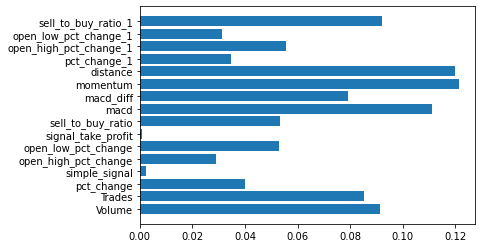

In [1231]:
plt.barh(list(X), model_tp.feature_importances_)

In [1232]:
# TODO:
# 1. Think on a model that would make for a good demo. There are several options:
#  a. Have labels that are related to some window in which the price changes significantly enough.
# We can reuse existing aggregations for such model.
#  b. Have a higher resolution of the aggregations (10k events instead of 1000 events for BTC). Can post-process existing data
# in fine resolution to arrive at new aggregations using a Python script.
#  c. Select a high-volume and high-volatility pair (e.g. ETHUSDT) that would yield signals more often.

In [1233]:
# df.dropna(inplace=True)

In [1234]:
# df.to_csv('ethbtc.csv', index=False)